### Notebook Description
This notebook is for using the extracted endmembers to perform telluric correction on new observations. The notebook serves as a way to validate extracted components by inspecting how well they can correct telluric lines.  

The notebook is set up to enable correction of multible observations.

If one wishes to perform correction on other spectra then either use the correction function from correction.py or load them into this notebook and run the corrections.

The notebook contains the following steps:
 1. Load packages and observations to correct (either a single observation or multiple observations)
 2. Fit the weights of the autoencoder telluric spectrum to the observations.
 3. Use fitted telluric spectra to perform corrections of the observations and inspect the results.

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
#Importing Packages
from scipy import interpolate
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from scipy.spatial import distance
from scipy import optimize
import pickle
import os
from continuum_normalisation import continuum_normalize
from optimiztion import opt
from optimiztion import opt_O2
from optimiztion import error
import time
from correction import telluric_fit
%matplotlib inline

### 1. Loading Flux and Wave Files
Load them in a way appropriate for the data at hand. The observed flux, wave and blaze files need to be loaded. The wavelength axis must be in units Angstrom (Å) in air in observatory restframe.

If observations are already blaze corrected then no need for the blaze funtion. The blaze corrections are only used for fitting the telluric weights. The output telluric spectra can still be used to correct non-blaze corrected observations.



#### Example of loading single spectrum
Here the validation observation from the paper plots is loaded. 

In [3]:
# Loading Validation observtion
fn  = '../validation_spectrum/HARPN.2020-11-03T10-18-23.184_e2ds_A.fits'
wv  = '../validation_spectrum/HARPN.2020-11-03T07-29-05.596_wave_A.fits'
blz = '../validation_spectrum/HARPN.2020-11-03T07-06-51.587_blaze_A.fits'

# Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
file_name = []
wave_name = []
blaze_name = []

flux, header = fits.getdata(fn, header=True)
wave, header = fits.getdata(wv, header=True)
blaze, header = fits.getdata(blz, header=True)

flux_obs_load.append(flux)
wave_obs_load.append(wave)
blaze_obs_load.append(blaze)      

file_name.append(fn)
wave_name.append(wv)
blaze_name.append(blz)     

flux_obs_load = np.asarray(flux_obs_load)
wave_obs_load = np.asarray(wave_obs_load)
blaze_obs_load = np.asarray(blaze_obs_load)

flux_obs_load=flux_obs_load/blaze_obs_load

In [3]:
def load_data(folder, solar=False):
    print('Loading Data...')
    # Initializing Arrays
    flux_obs_load  = []
    wave_obs_load  = []
    blaze_obs_load = []
    file_name = []
    wave_name = []
    blaze_name = []
    bary_obs_load = []

    for path, dirs, files in os.walk(folder):
        for file in files:
            fname = os.path.join(path, file)
            
            if file.endswith("e2ds_A.fits"):
                flux, header = fits.getdata(fname, header=True)
                flux_obs_load.append(flux)
                file_name.append(fname)
                
                bary = header['HIERARCH ESO DRS BERV']
                bary_obs_load.append(bary)
                
            if file.endswith("wave_A.fits"):
                wave = fits.getdata(fname)
                wave_obs_load.append(wave)
                wave_name.append(fname)
                
            if file.endswith("blaze_A.fits"):
                blaze = fits.getdata(fname)
                blaze_obs_load.append(blaze)
                blaze_name.append(fname)
            
    bary_obs_load = np.array(bary_obs_load)
    flux_obs_load = np.array(flux_obs_load)
    wave_obs_load = np.array(wave_obs_load)
    blaze_obs_load = np.array(blaze_obs_load)

    # Using BERV to get same wl as AE_tellurics 
    # Light speed in km/s
    if solar:
        c = 299792.458
        v=-bary_obs_load
        wave_obs_load = wave_obs_load * (1.0 + v[:, np.newaxis, np.newaxis] / c)    

    # blaze correction
    flux_obs_load = flux_obs_load / blaze_obs_load

    print('Done Loading')
    
    return flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name

In [4]:
flux_obs_load, wave_obs_load, blaze_obs_load, bary_obs_load, file_name, wave_name, blaze_name = load_data('/projects/data/HARPS/solar/2014', solar=True)

Loading Data...
Done Loading


In [5]:
print(flux_obs_load.shape, wave_obs_load.shape, blaze_obs_load.shape)

(770, 72, 4096) (770, 72, 4096) (770, 72, 4096)


### 2. Fitting the telluric spectrum

The telluric_fit function is used to fit the telluric spectrum of the observations. The output is the fitted telluric spectrum along with the weights of the H2O and O2 components.


Input spectra should not be continuum normalized. Input spectra should be blaze corrected.

In [6]:
# HARPS -> 72 orders, from 378-691 nm (89-161)
# HARPS-N -> 69 orders, from 385-691 nm (92-161) (?)
# TAU is trained on HARPS-N solar observation, so we need to cut the HARPS orders to match the HARPS-N orders

flux_obs_load, wave_obs_load, blaze_obs_load = flux_obs_load[:, 3:, :], wave_obs_load[:, 3:, :], blaze_obs_load[:, 3:, :]

In [7]:
telluric_spec,H2O_weights,O2_weights =  telluric_fit(flux_obs_load,wave_obs_load)

Initializing (~ 10 sec)...



/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  ntop = trial.suggest_uniform('ntop', 0.1, 4)   # sigma top for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  nbins = trial.suggest_uniform('nbins', 0.1, 4) # sigma bottom for continuum normalization
/home/m.gorsini/telluric-autoencoder-with-steroids/code/optimiztion.py:82: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  H2O_weight = trial.suggest_unif

Correcting observation 10/770
Correcting observation 20/770
Correcting observation 30/770
Correcting observation 40/770
Correcting observation 50/770
Correcting observation 60/770
Correcting observation 70/770
Correcting observation 80/770
Correcting observation 90/770
Correcting observation 100/770
Correcting observation 110/770
Correcting observation 120/770
Correcting observation 130/770
Correcting observation 140/770
Correcting observation 150/770
Correcting observation 160/770
Correcting observation 170/770
Correcting observation 180/770
Correcting observation 190/770
Correcting observation 200/770
Correcting observation 210/770
Correcting observation 220/770
Correcting observation 230/770
Correcting observation 240/770
Correcting observation 250/770
Correcting observation 260/770
Correcting observation 270/770
Correcting observation 280/770
Correcting observation 290/770
Correcting observation 300/770
Correcting observation 310/770
Correcting observation 320/770
Correcting observ

In [8]:
np.mean(H2O_weights), np.mean(O2_weights), H2O_weights.shape, O2_weights.shape

(-8.454265349307873, -6.317177368886836, (770,), (770,))

In [9]:
import torch
from training import AutoEncoder
from hyperparameters import hyperparams
from dataloader import dataloader


In [10]:
z_encs = []
# load model weights
for order in range(flux_obs_load.shape[1]):
    _, _,n_dim = hyperparams(order)
    
    # Collecting flux and wavelength for the aperture to train on
    flux = flux_obs_load[:,order]
    wave = wave_obs_load[:, order] 
    
    
    # Saving apertures with powerful tellurics to help train weaker apertures
    flux54 = flux_obs_load[:,54]
    wave54 = wave_obs_load[:, 54]
    flux60 = flux_obs_load[:,60]
    wave60 = wave_obs_load[:, 60]
    flux68 = flux_obs_load[:,68]
    wave68 = wave_obs_load[:, 68]

    # Stacking relevant strong telluric apertures to aid training
    if order in {56,59,60,61,62,65,66,67,68}:
        flux = np.hstack((flux54,flux_obs_load[:,order]))
        wave = np.hstack((wave54,wave_obs_load[:, order]))
    
    if order==58:
        flux = np.hstack((flux54,flux_obs_load[:,order],flux60))
        wave = np.hstack((wave54,wave_obs_load[:, order],wave60))  
        
    if order in {27,28,29,30,41,42,43,48,49,50,51,52}:
        flux = np.hstack((flux_obs_load[:,order],flux54,flux60))
        wave = np.hstack((wave_obs_load[:, order],wave54,wave60))
        
    if order in range(0,26+1) or order in range(31,40+1) or order in range(44,47+1):
        flux = np.hstack((flux_obs_load[:,order],flux54))
        wave = np.hstack((wave_obs_load[:, order],wave54))
    
    num_features = len(flux[0])
    pretrained = torch.load(f'/projects/data/HARPS/solar/2022/output/weights_{order}.pt')
    # model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=1, wave=wave)
    model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=len(flux), wave=wave)
    model.load_state_dict(pretrained['net_state_dict'])
    model.eval()

    z_enc = model.encoder(torch.from_numpy(flux.astype(np.float32))).detach().cpu().numpy()
    print(f"Order {order}: {z_enc=}")
    z_encs.append(z_enc)
    #print(f"Order {order}: {z=}")

Order 0: z_enc=array([[-1376.8917   ,  -450.08145  ],
       [-1698.3243   ,  -479.17664  ],
       [-1262.6348   ,  -392.10764  ],
       ...,
       [ -409.79324  ,  -126.16006  ],
       [ -210.20573  ,   -54.560555 ],
       [  -16.24887  ,    -3.4098997]], dtype=float32)
Order 1: z_enc=array([[ -500.3361   , -2161.5076   ],
       [ -636.5207   , -2623.4604   ],
       [ -478.744    , -1933.7688   ],
       ...,
       [ -143.12     ,  -614.40076  ],
       [  -84.98141  ,  -305.7049   ],
       [   -6.0614047,   -24.588652 ]], dtype=float32)
Order 2: z_enc=array([[ 1.4650727e+05, -1.0575294e+03],
       [ 1.7790817e+05, -1.2928744e+03],
       [ 1.3169639e+05, -1.0244557e+03],
       ...,
       [ 4.3086449e+04, -2.9427811e+02],
       [ 2.0757686e+04, -1.5560954e+02],
       [ 1.5527596e+03, -9.0268612e+00]], dtype=float32)
Order 3: z_enc=array([[  1796.9675 , 127241.055  ],
       [  5393.104  , 153260.86   ],
       [  2367.453  , 118545.4    ],
       ...,
       [  2295.4988

In [11]:

# load model weights
for order in range(flux_obs_load.shape[1]):
    _, _,n_dim = hyperparams(order)
    
    # Collecting flux and wavelength for the aperture to train on
    flux = flux_obs_load[:,order]
    wave = wave_obs_load[:, order] 
    
    
    # Saving apertures with powerful tellurics to help train weaker apertures
    flux54 = flux_obs_load[:,54]
    wave54 = wave_obs_load[:, 54]
    flux60 = flux_obs_load[:,60]
    wave60 = wave_obs_load[:, 60]
    flux68 = flux_obs_load[:,68]
    wave68 = wave_obs_load[:, 68]

    # Stacking relevant strong telluric apertures to aid training
    if order in {56,59,60,61,62,65,66,67,68}:
        flux = np.hstack((flux54,flux_obs_load[:,order]))
        wave = np.hstack((wave54,wave_obs_load[:, order]))
    
    if order==58:
        flux = np.hstack((flux54,flux_obs_load[:,order],flux60))
        wave = np.hstack((wave54,wave_obs_load[:, order],wave60))  
        
    if order in {27,28,29,30,41,42,43,48,49,50,51,52}:
        flux = np.hstack((flux_obs_load[:,order],flux54,flux60))
        wave = np.hstack((wave_obs_load[:, order],wave54,wave60))
        
    if order in range(0,26+1) or order in range(31,40+1) or order in range(44,47+1):
        flux = np.hstack((flux_obs_load[:,order],flux54))
        wave = np.hstack((wave_obs_load[:, order],wave54))
    
    num_features = len(flux[0])
    pretrained = torch.load(f'/projects/data/HARPS/solar/2022/output/weights_{order}.pt')
    model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=1, wave=wave)
    model.load_state_dict(pretrained['net_state_dict'])
    model.eval()

    z_enc = model.encoder(torch.from_numpy(flux.astype(np.float32)))
    print(f"Order {order}: {z_enc=}")
    #--- ---------------- Controlling endmember abundance range -------------------
    # z are the endmember abundance weights
    # Solar endmember abundance is constrained as a constant
    z_enc[:,0] = 1
    
    # H2O Endmember transforming to range [0,1]
    z_enc[:,1] = z_enc[:,1]-np.min(z_enc[:,1].detach().numpy())        # Casting to positive values 
    z_enc[:,1] = z_enc[:,1] / np.max(z_enc[:,1].detach().numpy())      # Normalizing to max value of 1
    print(f"Order {order}: {z_enc=}")
    # H2O Endmember transforming to range [c2,1]
    z_enc[:,1] = z_enc[:,1] +0.035                                 # Lower bound c2 = 1-1/(1+x). x=0.035 gives range [0.03,1]
    z_enc[:,1] = z_enc[:,1] / np.max(z_enc[:,1].detach().numpy())      # Normalizing to max value of 1
    print(f"Order {order}: {z_enc=}")
    if pretrained['latent_features']==3:
        # O2 Endmember transforming to range [0,1]
        z_enc[:,2] = z_enc[:,2]-np.min(z_enc[:,2].detach().numpy())    # Casting to positive values   
        z_enc[:,2] = z_enc[:,2] / np.max(z_enc[:,2].detach().numpy())  # Normalizing to max value of 1
        print(f"Order {order}: {z_enc=}")
        # O2 Endmember transforming to range [c3,1]
        z_enc[:,2] = z_enc[:,2] + 2.2                              # Lower bound c3 = 1-1/(1+x). x=2.2 gives range [0.69,1]
        z_enc[:,2] = z_enc[:,2] / np.max(z_enc[:,2].detach().numpy())  # Normalizing to max value of 1
    print(f"Order {order}: {z_enc=}")      
    # ------- Controlling endmember spectra range -------
    z_enc = z_enc.detach().cpu().numpy()
    # x_hat, z, decoder_weights = model(torch.from_numpy(flux.astype(np.float32)), 1.0)
    print(f"Order {order}: {z_enc=}")
    break
    #print(f"Order {order}: {z=}")
        

Order 0: z_enc=tensor([[-1376.8917,  -450.0815],
        [-1698.3243,  -479.1766],
        [-1262.6348,  -392.1076],
        ...,
        [ -409.7932,  -126.1601],
        [ -210.2057,   -54.5606],
        [  -16.2489,    -3.4099]], grad_fn=<NativeBatchNormBackward0>)
Order 0: z_enc=tensor([[1.0000, 0.5378],
        [1.0000, 0.5129],
        [1.0000, 0.5874],
        ...,
        [1.0000, 0.8149],
        [1.0000, 0.8761],
        [1.0000, 0.9199]], grad_fn=<CopySlices>)
Order 0: z_enc=tensor([[1.0000, 0.5534],
        [1.0000, 0.5294],
        [1.0000, 0.6013],
        ...,
        [1.0000, 0.8211],
        [1.0000, 0.8803],
        [1.0000, 0.9226]], grad_fn=<CopySlices>)
Order 0: z_enc=tensor([[1.0000, 0.5534],
        [1.0000, 0.5294],
        [1.0000, 0.6013],
        ...,
        [1.0000, 0.8211],
        [1.0000, 0.8803],
        [1.0000, 0.9226]], grad_fn=<CopySlices>)
Order 0: z_enc=array([[1.        , 0.55343044],
       [1.        , 0.529386  ],
       [1.        , 0.6013402

In [12]:
zs = []
# load model weights
for order in range(flux_obs_load.shape[1]):
    _, _,n_dim = hyperparams(order)
    
    # Collecting flux and wavelength for the aperture to train on
    flux = flux_obs_load[:,order]
    wave = wave_obs_load[:, order] 
    
    
    # Saving apertures with powerful tellurics to help train weaker apertures
    flux54 = flux_obs_load[:,54]
    wave54 = wave_obs_load[:, 54]
    flux60 = flux_obs_load[:,60]
    wave60 = wave_obs_load[:, 60]
    flux68 = flux_obs_load[:,68]
    wave68 = wave_obs_load[:, 68]

    # Stacking relevant strong telluric apertures to aid training
    if order in {56,59,60,61,62,65,66,67,68}:
        flux = np.hstack((flux54,flux_obs_load[:,order]))
        wave = np.hstack((wave54,wave_obs_load[:, order]))
    
    if order==58:
        flux = np.hstack((flux54,flux_obs_load[:,order],flux60))
        wave = np.hstack((wave54,wave_obs_load[:, order],wave60))  
        
    if order in {27,28,29,30,41,42,43,48,49,50,51,52}:
        flux = np.hstack((flux_obs_load[:,order],flux54,flux60))
        wave = np.hstack((wave_obs_load[:, order],wave54,wave60))
        
    if order in range(0,26+1) or order in range(31,40+1) or order in range(44,47+1):
        flux = np.hstack((flux_obs_load[:,order],flux54))
        wave = np.hstack((wave_obs_load[:, order],wave54))
    
    num_features = len(flux[0])
    pretrained = torch.load(f'/projects/data/HARPS/solar/2022/output/weights_{order}.pt')
    model = AutoEncoder(num_features=pretrained['num_features'], latent_features=pretrained['latent_features'], order=order, batch_size=1, wave=wave)
    model.load_state_dict(pretrained['net_state_dict'])
    model.eval()

    x_hat, z, decoder_weights = model(torch.from_numpy(flux.astype(np.float32)), bary_obs_load)
    print(f"Order {order}: {z=}, {z.shape=}")
    zs.append(z)


Order 0: z=tensor([[1.0000, 0.5534],
        [1.0000, 0.5294],
        [1.0000, 0.6013],
        ...,
        [1.0000, 0.8211],
        [1.0000, 0.8803],
        [1.0000, 0.9226]], grad_fn=<CopySlices>), z.shape=torch.Size([770, 2])
Order 1: z=tensor([[1.0000, 0.5658],
        [1.0000, 0.4762],
        [1.0000, 0.6100],
        ...,
        [1.0000, 0.8659],
        [1.0000, 0.9258],
        [1.0000, 0.9803]], grad_fn=<CopySlices>), z.shape=torch.Size([770, 2])
Order 2: z=tensor([[1.0000, 0.5429],
        [1.0000, 0.4544],
        [1.0000, 0.5553],
        ...,
        [1.0000, 0.8298],
        [1.0000, 0.8820],
        [1.0000, 0.9371]], grad_fn=<CopySlices>), z.shape=torch.Size([770, 2])
Order 3: z=tensor([[1.0000, 0.4573],
        [1.0000, 0.5440],
        [1.0000, 0.4284],
        ...,
        [1.0000, 0.1544],
        [1.0000, 0.0982],
        [1.0000, 0.0378]], grad_fn=<CopySlices>), z.shape=torch.Size([770, 2])
Order 4: z=tensor([[1.0000, 0.0424],
        [1.0000, 0.0381],
     

In [52]:
O2_weights[0], np.mean([zs[i][:, 2].mean().detach().cpu().numpy() for i in range(69) if zs[i].shape[1] == 3]), zs[60][:, 2].mean().detach().cpu().numpy()

(-3.42564758229732, 0.8082068, array(0.73885626, dtype=float32))

In [53]:
H2O_weights[0], np.mean([zs[i][:, 1].mean().detach().cpu().numpy() for i in range(69)]), zs[53][:, 1].mean().detach().cpu().numpy(), zs[54][:, 1].mean().detach().cpu().numpy()

(0.41646792674145644,
 0.5439653,
 array(0.84075236, dtype=float32),
 array(0.8402847, dtype=float32))

In [59]:
O2_weights[4], zs[60][4, 2], zs[60].shape
    

(1.1278126014064755,
 tensor(0.8003, grad_fn=<SelectBackward0>),
 torch.Size([770, 3]))

### Tellurics

In [13]:
# open tellurics HARPS
import pickle
pkl_file = open('/projects/data/HARPS/solar/2022/output/tellurics.pkl', 'rb')
tell_hs = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('../tellurics/tellurics.pkl', 'rb')
tell_hn = pickle.load(pkl_file)
pkl_file.close()

In [14]:
tell_hs.shape, tell_hn.shape

((69, 3, 4096), (69, 3, 4096))

In [15]:
tell_hs[0, 0], tell_hn[0, 0]

(array([3852.        , 3852.01025641, 3852.02051282, ..., 3893.97948718,
        3893.98974359, 3894.        ]),
 array([3875.        , 3875.01025641, 3875.02051282, ..., 3916.97948718,
        3916.98974359, 3917.        ]))

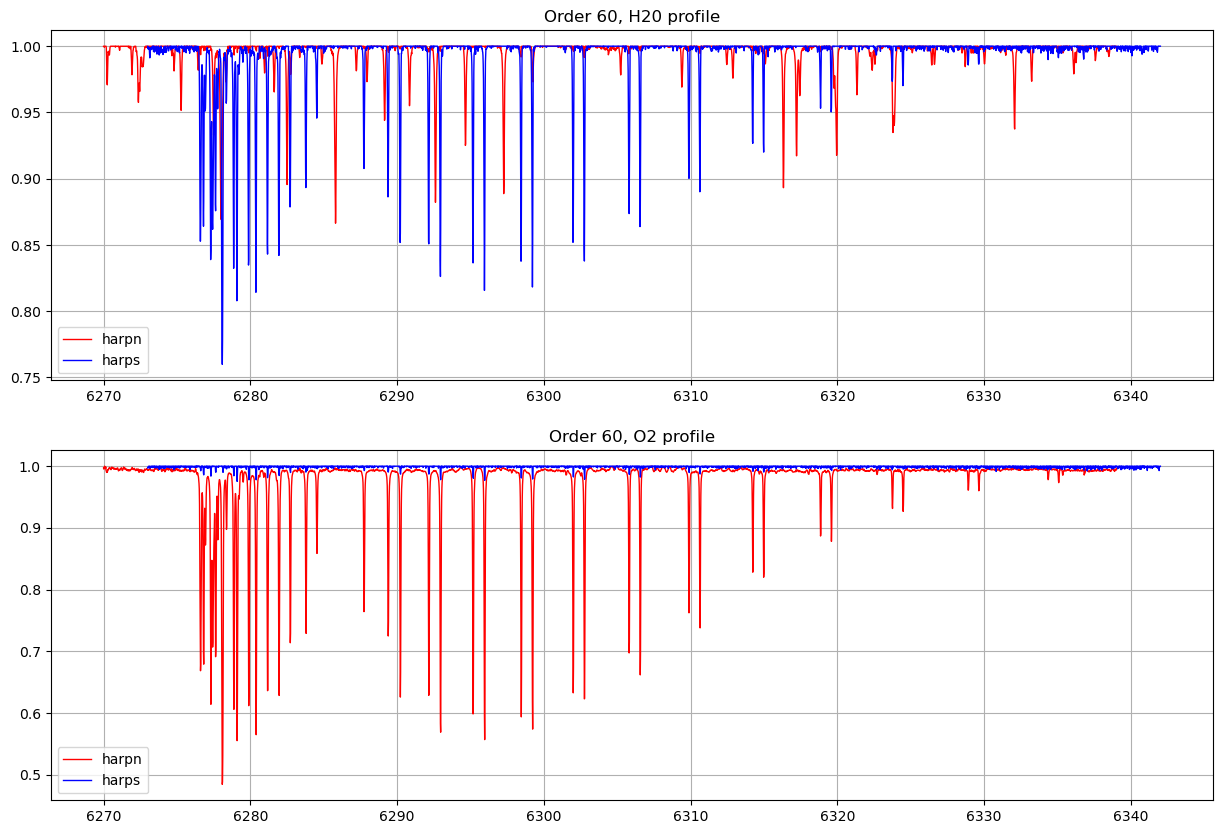

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].grid(True)
axs[0].plot(tell_hn[60, 0], tell_hn[60, 1], color='r', label='harpn', linewidth=1.0)
axs[0].plot(tell_hs[60, 0], tell_hs[60, 1], color='b', label='harps', linewidth=1.0)
axs[0].set_title('Order 60, H20 profile')
axs[0].legend()

axs[1].grid(True)
axs[1].plot(tell_hn[60, 0], tell_hn[60, 2], color='r', label='harpn', linewidth=1.0)
axs[1].plot(tell_hs[60, 0], tell_hs[60, 2], color='b', label='harps', linewidth=1.0)
axs[1].legend()
axs[1].set_title('Order 60, O2 profile')
fig.show()

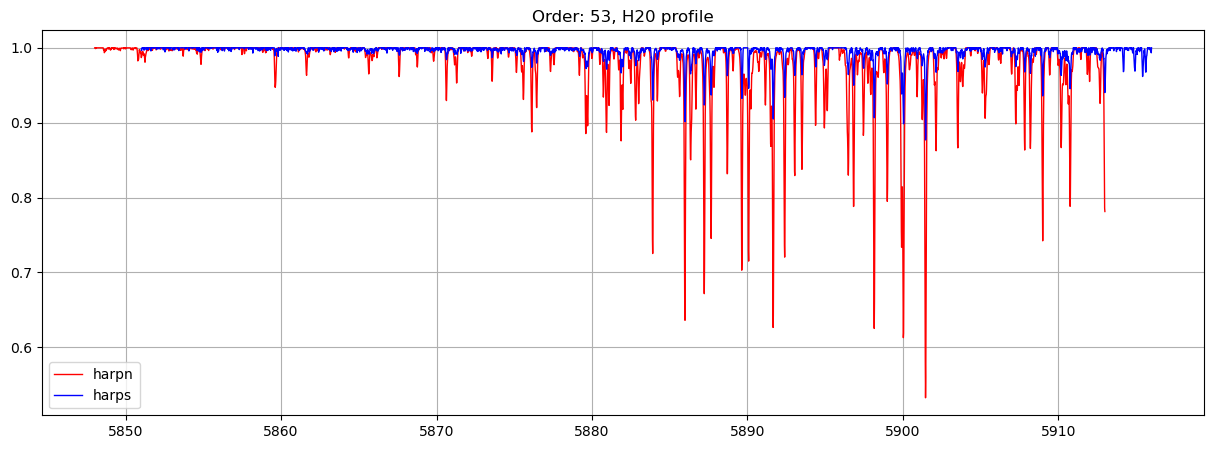

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True)
ax.plot(tell_hn[53, 0], tell_hn[53, 1], color='r', label='harpn', linewidth=1.0)
ax.plot(tell_hs[53, 0], tell_hs[53, 1], color='b', label='harps', linewidth=1.0)
ax.set_title('Order: 53, H20 profile')
ax.legend()
fig.show()

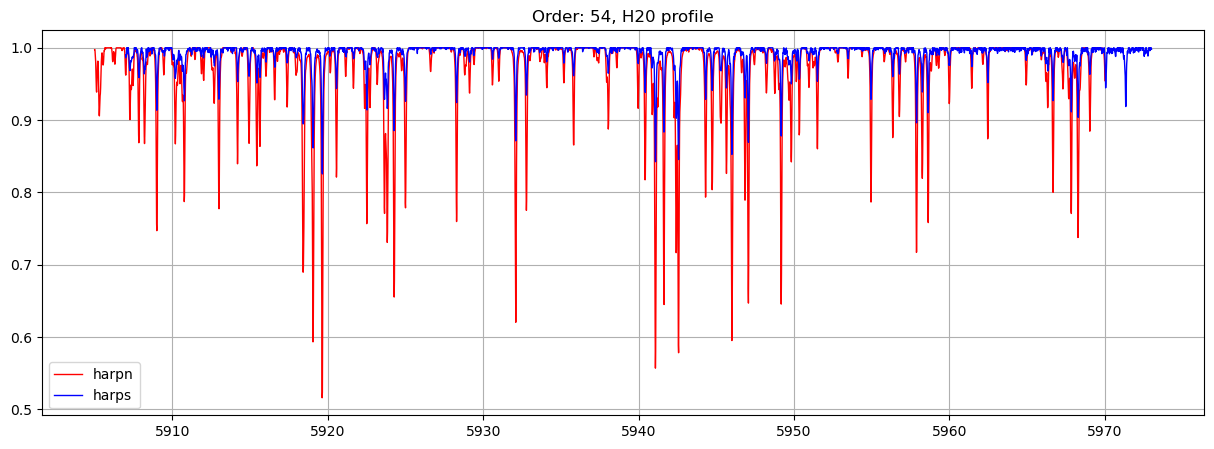

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True)
ax.plot(tell_hn[54, 0], tell_hn[54, 1], color='r', label='harpn', linewidth=1.0)
ax.plot(tell_hs[54, 0], tell_hs[54, 1], color='b', label='harps', linewidth=1.0)
ax.set_title('Order: 54, H20 profile')
ax.legend()
fig.show()

In [19]:
# telluric_spec[0] = h2o_weight * tell_hn[0, 1] + o2_weight * tell_hn[0, 2]
telluric_spec.shape

(770, 69, 4096)

In [20]:
wave_obs_load.shape, flux_obs_load.shape

((770, 69, 4096), (770, 69, 4096))

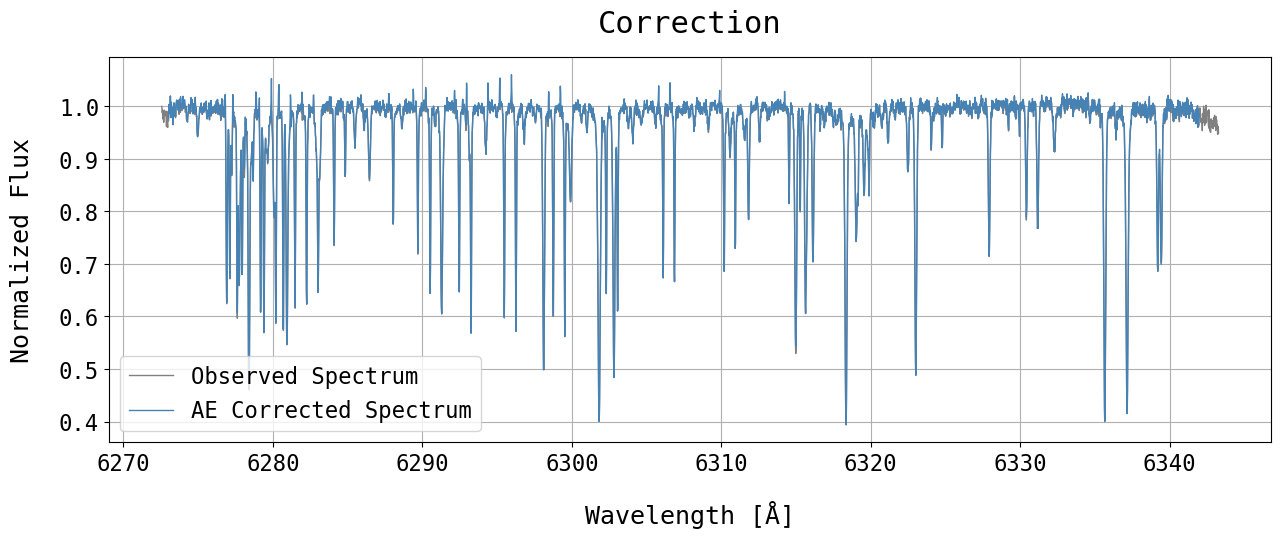

In [21]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(15, 5))
linewidth=1.0

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)
#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

In [22]:
np.sqrt(np.nanmean((obs/cont - obs/telluric_spec[obs_nr,order]/cont) ** 2))

0.005714839716924375

In [40]:
h2o_weight, o2_weight = zs[order][obs_nr, 1:].detach().cpu().numpy()
h2o_weight, o2_weight, H2O_weights[obs_nr], O2_weights[obs_nr]

(0.8115905, 0.7435743, 0.08104869241957986, 1.991861788906499)

In [30]:
# Applying fitted weights to all orders
Data1 =  tell_hn[:,1]*h2o_weight + (1-h2o_weight)
Data2 =  tell_hn[:,2]*o2_weight  + (1-o2_weight)

# Combining H2O and O2 spectra
AE_combined = Data1*Data2
AE_combined = np.clip(AE_combined,0,1) # If the weights are very large control that there is not negative transmission

# Interpolating combined AE to observed
wave = tell_hn[:,0]
AE_interp = np.zeros(wave_obs_load.shape)
for i in range(0,69): 
    f = interpolate.interp1d(wave[i], AE_combined[i],bounds_error=False,fill_value=np.nan,kind='quadratic')
    AE_interp[obs_nr,i, :]  = f(wave_obs_load[obs_nr, i, :])


In [31]:
AE_interp.shape

(770, 69, 4096)

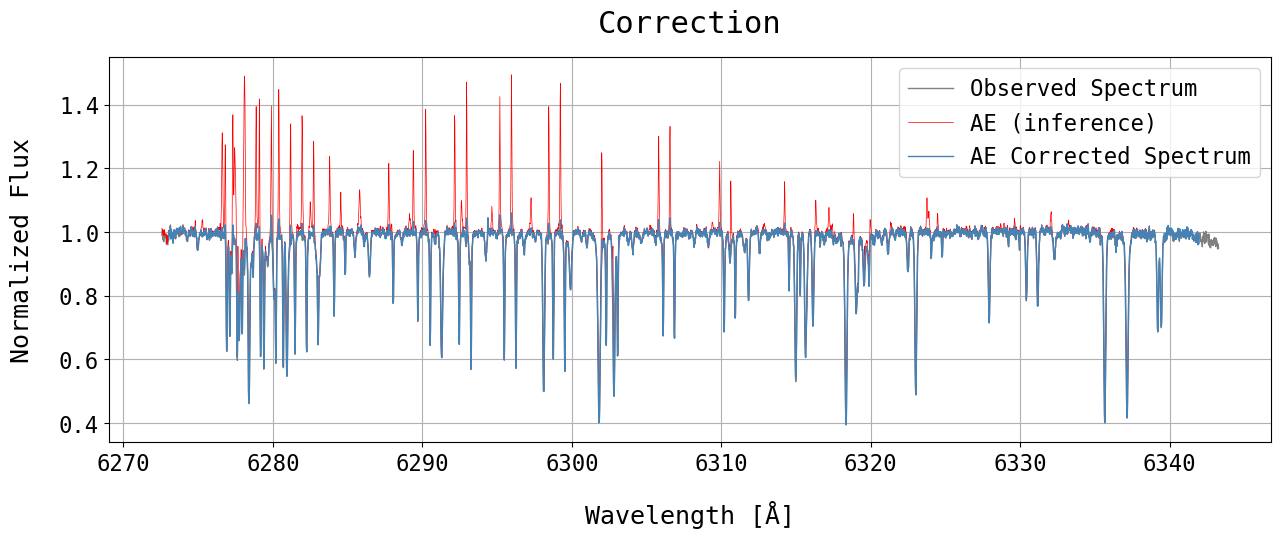

In [38]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(15, 5))
linewidth=1.0

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],obs/cont,color='grey',label='Observed Spectrum',linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],obs/AE_interp[obs_nr,order]/cont,color='red',label='AE (inference)',linewidth=0.5)
plt.plot(wave_obs_load[obs_nr,order],obs/telluric_spec[obs_nr,order]/cont,color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)

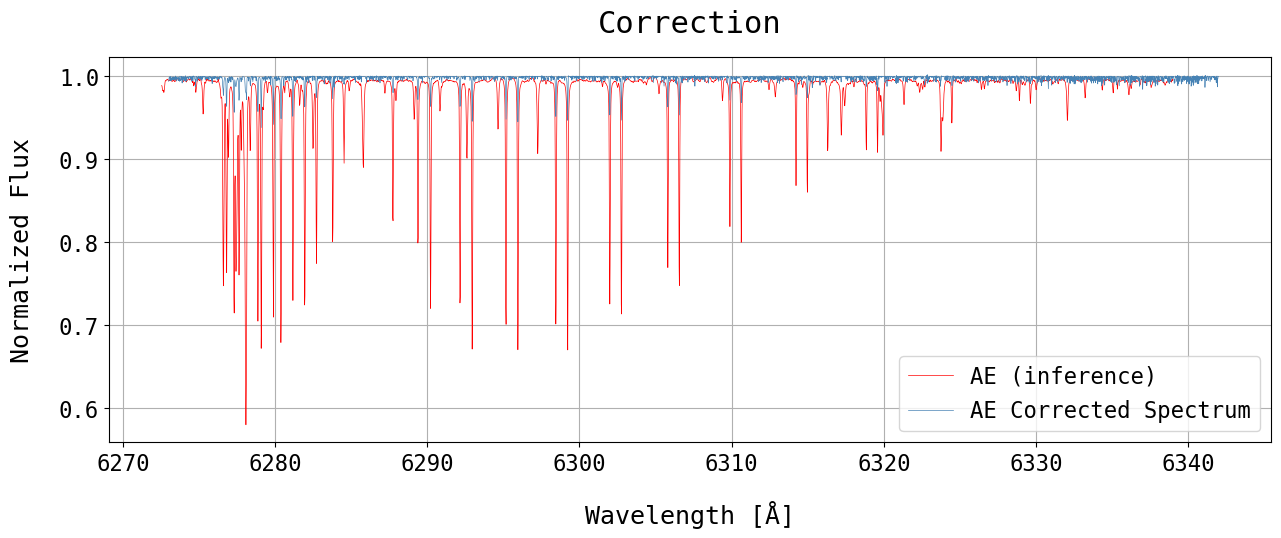

In [39]:
obs_nr=93
order=60
font = {'fontname':'DejaVu Sans Mono'}
plt.figure(figsize=(15, 5))
linewidth=0.5

ntop  = 0.613   # parameters for continuum normalization
nbottom = 1.933 # parameter for continuum normalization
    
obs = flux_obs_load[obs_nr,order] #/ blaze_obs_load[obs_nr,order]
cont = continuum_normalize(wave_obs_load[obs_nr,order],obs,n_sigma=[ntop,nbottom])
plt.plot(wave_obs_load[obs_nr,order],AE_interp[obs_nr, order], color='red',label='AE (inference)', linewidth=linewidth)
plt.plot(wave_obs_load[obs_nr,order],telluric_spec[obs_nr,order],color='steelblue',label='AE Corrected Spectrum',linewidth=linewidth)

#plt.axis([5880.1,5910.3,0,1.5]) # 53
# plt.axis([6540,6583,0.15,1.12])  # 64
fontsize=18
plt.legend(prop={'family': 'DejaVu Sans Mono','size': fontsize-2},loc='best')
plt.xlabel('Wavelength [Å]',**font,fontsize=fontsize,labelpad=fontsize)
plt.ylabel('Normalized Flux',**font,fontsize=fontsize,labelpad=fontsize)
plt.title('Correction',**font,fontsize=fontsize+4,pad=fontsize);
plt.xticks(fontsize=fontsize-2,**font);
plt.yticks(fontsize=fontsize-2,**font);
plt.grid(True)